# Adaptive Captcha

Implementation of the paper on https://www.kaggle.com/datasets/parsasam/captcha-dataset


In [1]:
!pip install --upgrade torch-summary

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm

In [3]:
DATA_DIR='/kaggle/input/captcha-dataset'
BATCH_SIZE=128
VAL_SPLIT=0.05

#AFFN
AFFN_KERNEL=5
AFFN_STRIDE=1
AFFN_DEPTH=4

#CRNN
CRNN_KERNEL=5
CRNN_POOL_KERNEL=2
CRNN_DROPOUT=0.3
CRNN_LATENT=128
LSTM_HIDDEN_DIM=32
VOCAB_SIZE=26*2+10
OUTPUT_LENGTH=5

#Train
SAVE_EPOCH=10
VAL_EPOCH=1
EPOCHS=40

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import string


def get_dataloaders(data_dir, batch_size=32, val_split=0.2, shuffle=True, num_workers=2):
    """
    Creates PyTorch dataloaders for training and validation with one-hot encoded labels.
    
    Parameters:
        data_dir (str): Path to the folder containing images.
        batch_size (int): Batch size for dataloaders.
        val_split (float): Fraction of data to use for validation.
        shuffle (bool): Whether to shuffle data.
        num_workers (int): Number of workers for dataloaders.

    Returns:
        train_loader, val_loader: DataLoaders for training and validation.
    """
    # Define the character set (vocabulary)
    characters = string.ascii_letters + string.digits  # Uppercase + lowercase + digits
    char_to_idx = {char: idx for idx, char in enumerate(characters)}
    vocab_size = len(characters)

    class CustomDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
            self.labels = [os.path.basename(f).split('.')[0] for f in self.image_paths]  # Extract filename as label
        
        def __len__(self):
            return len(self.image_paths)
        
        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            label_str = self.labels[idx]
            
            # Convert label string to one-hot encoded tensor
            label_indices = [char_to_idx[c] for c in label_str if c in char_to_idx]  # Map characters to indices
            label_tensor = torch.zeros(len(label_indices),dtype=torch.long)  # One-hot encoding tensor
            for i, index in enumerate(label_indices):
                label_tensor[i] = index  # Set one-hot encoding
            
            if self.transform:
                image = self.transform(image)
            
            return image, label_tensor
    
    transform = transforms.Compose([
        transforms.Resize((40, 150)),  # Resize to a fixed size
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Lambda(lambda x: x / 255),
    ])
    
    dataset = CustomDataset(root_dir=data_dir, transform=transform)
    
    # Compute train-validation split
    total_size = len(dataset)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader


In [6]:
train_loader,val_loader=get_dataloaders(DATA_DIR, batch_size=BATCH_SIZE, val_split=VAL_SPLIT, shuffle=True)

In [7]:
for X,y in train_loader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([128, 1, 40, 150])
torch.Size([128, 5])


## AFFN


In [8]:
class Encoder(nn.Sequential):
    def __init__(self,n,kernel_size,stride):
        super().__init__(
            nn.Conv2d(in_channels=4**(n-1),out_channels=4**n,kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(num_features=4**n),
            nn.ReLU(inplace=False)
        )

In [9]:
# summary(Encoder(2,AFFN_KERNEL,AFFN_STRIDE),(4,36,146))

In [10]:
class Decoder(nn.Sequential):
    def __init__(self,n,kernel_size,stride):
        super().__init__(
            nn.ConvTranspose2d(in_channels=4**n,out_channels=4**(n-1),kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(num_features=4**(n-1)),
            nn.ReLU(inplace=False)
        )

In [11]:
# summary(Decoder(2,AFFN_KERNEL,AFFN_STRIDE),(16,32,142))

In [ ]:
class AFFN(nn.Module):
    def __init__(self,n):
        super().__init__()
        self.n=n
        # self.test=nn.Linear(1,2)
        self.alpha=nn.Parameter(torch.randn(n-1).to(device)).to(device)
        self.encoders=[]
        for i in range(1,n+1):
            self.encoders.append(Encoder(i,AFFN_KERNEL,AFFN_STRIDE).to(device))

        self.decoders=[]
        for i in range(n,0,-1):
            self.decoders.append(Decoder(i,AFFN_KERNEL,AFFN_STRIDE).to(device))
            
    def forward(self, x):
        residuals = []
        for i, enc in enumerate(self.encoders):
            x = enc(x)
            if i < self.n - 1:
                x = x * (1 - self.alpha[i])  
                residuals.append(x * self.alpha[i])
    
        for i, dec in enumerate(self.decoders):
            x = dec(x)
            if i < self.n - 1:
                x = x + residuals.pop()
    
        return x
        

## CRNN


In [14]:
class CRNN(nn.Module):
    def __init__(self,in_channels,kernel_size,pool_kernel_size,dropout,latent_dim,lstm_hidden_dim,vocab_size,output_length):
        super().__init__()
        self.lstm_hidden_dim=lstm_hidden_dim
        self.output_length=output_length
        
        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=in_channels*2,kernel_size=kernel_size,padding=2),
            nn.BatchNorm2d(num_features=in_channels*2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )

        self.conv2=nn.Sequential(
                    nn.Conv2d(in_channels=in_channels*2,out_channels=in_channels*4,kernel_size=kernel_size,padding=2),
                    nn.BatchNorm2d(num_features=in_channels*4),
                    nn.ReLU(inplace=False),
                    nn.MaxPool2d(kernel_size=pool_kernel_size)
                )

        self.flatten=nn.Flatten()
        self.dropout=nn.Dropout(dropout)

        self.latent_fc=nn.LazyLinear(latent_dim)

        self.lstm=nn.LSTM(input_size=latent_dim,hidden_size=lstm_hidden_dim,num_layers=1)

        self.output_fc=nn.Linear(lstm_hidden_dim,vocab_size)
        self.softmax=nn.Softmax()

    def forward(self,x):
        conv1_out=self.conv1(x)
        conv2_out=self.conv2(conv1_out)
        flattened=self.flatten(conv2_out)
        dropped=self.dropout(flattened)
        final=self.latent_fc(dropped)

        output=[]

        h,c=torch.zeros(1,self.lstm_hidden_dim).to(device),torch.zeros(1,self.lstm_hidden_dim).to(device)
        for i in range(self.output_length):
            out,(h,c)=self.lstm(final,(h,c))
            out=self.output_fc(out)
            out_softmax=F.softmax(out,dim=-1)
            output.append(out_softmax)
        output=torch.permute(torch.stack(output),(1,2,0))
        return output

In [ ]:
class CRNN(nn.Module):
    def __init__(self, in_channels, kernel_size, pool_kernel_size, dropout, latent_dim, lstm_hidden_dim, vocab_size, output_length=5):
        super().__init__()
        self.lstm_hidden_dim = lstm_hidden_dim
        self.output_length = output_length  # Should be 5 for 5 characters
        self.vocab_size = vocab_size
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels*2, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels*2, out_channels=in_channels*4, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*4),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)
        self.latent_fc = nn.LazyLinear(latent_dim)
        self.lstm = nn.LSTM(input_size=latent_dim, hidden_size=lstm_hidden_dim, num_layers=1, batch_first=True)
        self.output_fc = nn.Linear(lstm_hidden_dim, vocab_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # CNN feature extraction
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(conv1_out)
        flattened = self.flatten(conv2_out)
        dropped = self.dropout(flattened)
        latent = self.latent_fc(dropped)
        
        lstm_input = latent.unsqueeze(1) 
        
        # Initialize hidden and cell states
        h0 = torch.zeros(1, batch_size, self.lstm_hidden_dim, device=x.device)
        c0 = torch.zeros(1, batch_size, self.lstm_hidden_dim, device=x.device)
        
        outputs = []
        
        # Generate 5 characters sequentially
        for _ in range(self.output_length):
            out, (h0, c0) = self.lstm(lstm_input, (h0, c0))  # out shape: (batch_size, 1, lstm_hidden_dim)
            
            logits = self.output_fc(out.squeeze(1))  # Shape: (batch_size, vocab_size)
            
            outputs.append(logits)

        outputs = torch.stack(outputs, dim=1)  # Shape: (batch_size, 5, vocab_size)
        
        return outputs

In [16]:
output=CRNN(64,CRNN_KERNEL,CRNN_POOL_KERNEL,CRNN_DROPOUT,CRNN_LATENT,LSTM_HIDDEN_DIM,VOCAB_SIZE,OUTPUT_LENGTH).to(device)(torch.zeros((2,64,256,256)).to(device))

In [17]:
output.shape

torch.Size([2, 5, 62])

In [18]:
class CaptchaCrackNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.affn=AFFN(AFFN_DEPTH).to(device)

        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2=nn.Sequential(
                    nn.Conv2d(in_channels=32,out_channels=48,kernel_size=5,padding=2),
                    nn.ReLU(inplace=False),
                    nn.MaxPool2d(kernel_size=2)
                )

        self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=48,out_channels=64,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        )

        self.res=nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=2)

        self.crnn=CRNN(64,CRNN_KERNEL,CRNN_POOL_KERNEL,CRNN_DROPOUT,CRNN_LATENT,LSTM_HIDDEN_DIM,VOCAB_SIZE,OUTPUT_LENGTH).to(device)

    def forward(self,x):
        affn_out=self.affn(x)
        res_out=self.res(x)
        conv1_out=self.conv1(affn_out)
        conv2_out=self.conv2(conv1_out+res_out)
        conv3_out=self.conv3(conv2_out)
        output=self.crnn(conv3_out)
        return output
        

In [19]:
CaptchaCrackNet()

CaptchaCrackNet(
  (affn): AFFN()
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (crnn): CRNN(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [22]:
def loss_fn(preds,target):
    ce_loss=F.cross_entropy(preds,target)
    # ctc_loss=F.ctc_loss(preds,target,torch.tensor(OUTPUT_LENGTH),torch.tensor(OUTPUT_LENGTH))

    # total_loss=ce_loss#+ctc_loss
    return ce_loss


def train(model,train_loader,val_loader,optimizer,loss_fn,epochs):
    train_history=[]
    val_history=[]
    model.to(device)
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}:")
        model.train()
        avg_loss=0
        for batch_num,(X,y) in enumerate(tqdm(train_loader,desc="Progress: ")):
            X=X.to(device)
            y=y.to(device)
            optimizer.zero_grad()
            preds=model(X)
            
            loss=loss_fn(preds.view(-1, VOCAB_SIZE),y.view(-1))
            loss.backward()
            optimizer.step()
            
            avg_loss+=loss.item()
        avg_loss/=len(train_loader)
        train_history.append(avg_loss)
        print(f"Loss: {avg_loss}")

        eval_loss=0
        if VAL_EPOCH and epoch%VAL_EPOCH==0:
            model.eval()
            with torch.no_grad():
                for batch_num,(X,y) in enumerate(tqdm(val_loader,desc="Progress: ")):
                    X=X.to(device)
                    y=y.to(device)
                    preds=model(X)
                    loss=loss_fn(preds.view(-1, VOCAB_SIZE),y.view(-1))
        
                    eval_loss+=loss.item()
                eval_loss/=len(val_loader)
                val_history.append(eval_loss)
                print(f"Val Loss: {eval_loss}",eval_loss)

        if SAVE_EPOCH and epoch%SAVE_EPOCH==0:
            print("Saving model")
            path=str(epoch)+'.pth'
            torch.save(model.state_dict(), path)
    torch.save(model.state_dict(),'final.pth')
    return train_history,val_history

In [23]:
model=CaptchaCrackNet().to(device)
optimizer=torch.optim.Adam(model.parameters())

In [24]:
train_history,val_history=train(model,train_loader,val_loader,optimizer,nn.CrossEntropyLoss(),EPOCHS)

Epoch 1:


Progress: 100%|██████████| 840/840 [05:36<00:00,  2.50it/s]


Loss: 4.077705801668621


Progress: 100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


Val Loss: 4.060507509443495 4.060507509443495
Epoch 2:


Progress: 100%|██████████| 840/840 [02:36<00:00,  5.38it/s]


Loss: 4.022004405941282


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.44it/s]


Val Loss: 3.9996608628167047 3.9996608628167047
Epoch 3:


Progress: 100%|██████████| 840/840 [02:35<00:00,  5.42it/s]


Loss: 3.948636395022983


Progress: 100%|██████████| 45/45 [00:07<00:00,  5.66it/s]


Val Loss: 3.9257496251000297 3.9257496251000297
Epoch 4:


Progress: 100%|██████████| 840/840 [02:43<00:00,  5.13it/s]


Loss: 3.854771889959063


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.47it/s]


Val Loss: 3.7686371750301784 3.7686371750301784
Epoch 5:


Progress: 100%|██████████| 840/840 [02:37<00:00,  5.35it/s]


Loss: 3.5890312319710143


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.46it/s]


Val Loss: 3.408281103769938 3.408281103769938
Epoch 6:


Progress: 100%|██████████| 840/840 [02:34<00:00,  5.44it/s]


Loss: 3.181332773537863


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.45it/s]


Val Loss: 2.9125840346018474 2.9125840346018474
Epoch 7:


Progress: 100%|██████████| 840/840 [02:33<00:00,  5.48it/s]


Loss: 2.7179303401992434


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.39it/s]


Val Loss: 2.5070218563079836 2.5070218563079836
Epoch 8:


Progress: 100%|██████████| 840/840 [02:37<00:00,  5.33it/s]


Loss: 2.358887299469539


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.59it/s]


Val Loss: 2.1798188739352757 2.1798188739352757
Epoch 9:


Progress: 100%|██████████| 840/840 [02:32<00:00,  5.52it/s]


Loss: 2.0779299604041235


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.56it/s]


Val Loss: 1.8987126323911878 1.8987126323911878
Epoch 10:


Progress: 100%|██████████| 840/840 [02:32<00:00,  5.50it/s]


Loss: 1.818781491404488


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.20it/s]


Val Loss: 1.659015989303589 1.659015989303589
Saving model
Epoch 11:


Progress: 100%|██████████| 840/840 [02:39<00:00,  5.28it/s]


Loss: 1.6049985417297907


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.60it/s]


Val Loss: 1.495680030186971 1.495680030186971
Epoch 12:


Progress: 100%|██████████| 840/840 [02:31<00:00,  5.54it/s]


Loss: 1.4386764807360513


Progress: 100%|██████████| 45/45 [00:07<00:00,  5.68it/s]


Val Loss: 1.3311320384343466 1.3311320384343466
Epoch 13:


Progress: 100%|██████████| 840/840 [02:33<00:00,  5.49it/s]


Loss: 1.3078664588076727


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.45it/s]


Val Loss: 1.2313578075832792 1.2313578075832792
Epoch 14:


Progress: 100%|██████████| 840/840 [02:31<00:00,  5.53it/s]


Loss: 1.1968632409969966


Progress: 100%|██████████| 45/45 [00:07<00:00,  5.72it/s]


Val Loss: 1.1237595001856486 1.1237595001856486
Epoch 15:


Progress: 100%|██████████| 840/840 [02:35<00:00,  5.39it/s]


Loss: 1.102551771913256


Progress: 100%|██████████| 45/45 [00:07<00:00,  5.73it/s]


Val Loss: 1.0561993877092997 1.0561993877092997
Epoch 16:


Progress: 100%|██████████| 840/840 [02:35<00:00,  5.40it/s]


Loss: 1.021106191476186


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.19it/s]


Val Loss: 0.9942915081977844 0.9942915081977844
Epoch 17:


Progress: 100%|██████████| 840/840 [02:31<00:00,  5.56it/s]


Loss: 0.9530354895052455


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.57it/s]


Val Loss: 0.9398895329899258 0.9398895329899258
Epoch 18:


Progress: 100%|██████████| 840/840 [02:33<00:00,  5.47it/s]


Loss: 0.8953236938942046


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.61it/s]


Val Loss: 0.8901027957598369 0.8901027957598369
Epoch 19:


Progress: 100%|██████████| 840/840 [02:34<00:00,  5.45it/s]


Loss: 0.8453428164834068


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.62it/s]


Val Loss: 0.862260209189521 0.862260209189521
Epoch 20:


Progress: 100%|██████████| 840/840 [02:34<00:00,  5.45it/s]


Loss: 0.8015024635053817


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.40it/s]


Val Loss: 0.8378677752282885 0.8378677752282885
Saving model
Epoch 21:


Progress: 100%|██████████| 840/840 [02:36<00:00,  5.36it/s]


Loss: 0.7629245455066364


Progress: 100%|██████████| 45/45 [00:09<00:00,  4.99it/s]


Val Loss: 0.8004685759544372 0.8004685759544372
Epoch 22:


Progress: 100%|██████████| 840/840 [02:42<00:00,  5.18it/s]


Loss: 0.7280396692809604


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.46it/s]


Val Loss: 0.7739739629957411 0.7739739629957411
Epoch 23:


Progress: 100%|██████████| 840/840 [02:41<00:00,  5.21it/s]


Loss: 0.6981941361512457


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.50it/s]


Val Loss: 0.7622136937247382 0.7622136937247382
Epoch 24:


Progress: 100%|██████████| 840/840 [02:43<00:00,  5.12it/s]


Loss: 0.6678832892151106


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.41it/s]


Val Loss: 0.7411464585198296 0.7411464585198296
Epoch 25:


Progress: 100%|██████████| 840/840 [02:43<00:00,  5.13it/s]


Loss: 0.6423358823571886


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.34it/s]


Val Loss: 0.7197104864650302 0.7197104864650302
Epoch 26:


Progress: 100%|██████████| 840/840 [02:32<00:00,  5.52it/s]


Loss: 0.6193945585971787


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.55it/s]


Val Loss: 0.7199385470814175 0.7199385470814175
Epoch 27:


Progress: 100%|██████████| 840/840 [02:32<00:00,  5.51it/s]


Loss: 0.5976354570970649


Progress: 100%|██████████| 45/45 [00:07<00:00,  5.72it/s]


Val Loss: 0.7013459020190769 0.7013459020190769
Epoch 28:


Progress: 100%|██████████| 840/840 [02:33<00:00,  5.46it/s]


Loss: 0.5789948375806921


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.37it/s]


Val Loss: 0.6928063856230842 0.6928063856230842
Epoch 29:


Progress: 100%|██████████| 840/840 [02:37<00:00,  5.32it/s]


Loss: 0.5602234815912587


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.35it/s]


Val Loss: 0.6779887451065911 0.6779887451065911
Epoch 30:


Progress: 100%|██████████| 840/840 [02:38<00:00,  5.31it/s]


Loss: 0.5442513941654137


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.39it/s]


Val Loss: 0.6686866958936055 0.6686866958936055
Saving model
Epoch 31:


Progress: 100%|██████████| 840/840 [02:35<00:00,  5.40it/s]


Loss: 0.5290909376882371


Progress: 100%|██████████| 45/45 [00:07<00:00,  5.74it/s]


Val Loss: 0.6626660294002957 0.6626660294002957
Epoch 32:


Progress: 100%|██████████| 840/840 [02:34<00:00,  5.42it/s]


Loss: 0.5159833499008701


Progress: 100%|██████████| 45/45 [00:07<00:00,  5.64it/s]


Val Loss: 0.6567494538095262 0.6567494538095262
Epoch 33:


Progress: 100%|██████████| 840/840 [02:31<00:00,  5.53it/s]


Loss: 0.5016184472966762


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.49it/s]


Val Loss: 0.660187037785848 0.660187037785848
Epoch 34:


Progress: 100%|██████████| 840/840 [02:33<00:00,  5.49it/s]


Loss: 0.48857036573546275


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.31it/s]


Val Loss: 0.6524229831165738 0.6524229831165738
Epoch 35:


Progress: 100%|██████████| 840/840 [02:33<00:00,  5.46it/s]


Loss: 0.47699886312087375


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.58it/s]


Val Loss: 0.657774461640252 0.657774461640252
Epoch 36:


Progress: 100%|██████████| 840/840 [02:33<00:00,  5.46it/s]


Loss: 0.46680815730776104


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.36it/s]


Val Loss: 0.6505114091767206 0.6505114091767206
Epoch 37:


Progress: 100%|██████████| 840/840 [02:34<00:00,  5.45it/s]


Loss: 0.4561045372060367


Progress: 100%|██████████| 45/45 [00:07<00:00,  5.67it/s]


Val Loss: 0.6458626866340638 0.6458626866340638
Epoch 38:


Progress: 100%|██████████| 840/840 [02:33<00:00,  5.46it/s]


Loss: 0.4465713257945719


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.61it/s]


Val Loss: 0.6411240379015605 0.6411240379015605
Epoch 39:


Progress: 100%|██████████| 840/840 [02:31<00:00,  5.54it/s]


Loss: 0.43539157456585337


Progress: 100%|██████████| 45/45 [00:08<00:00,  5.47it/s]


Val Loss: 0.6337936441103618 0.6337936441103618
Epoch 40:


Progress: 100%|██████████| 840/840 [02:32<00:00,  5.52it/s]


Loss: 0.42840138191268556


Progress: 100%|██████████| 45/45 [00:07<00:00,  5.71it/s]

Val Loss: 0.637671340836419 0.637671340836419
Saving model


In [ ]:
characters = string.ascii_letters + string.digits
idx_to_char = {idx: char for idx, char in enumerate(characters)}
def to_text(arr):
    ans=''
    for c in arr:
        ans=ans+idx_to_char[c.item()]
    return ans

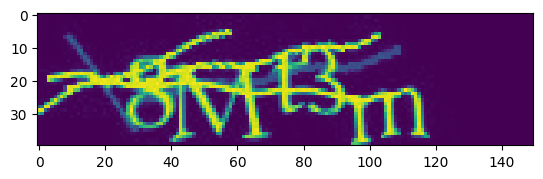

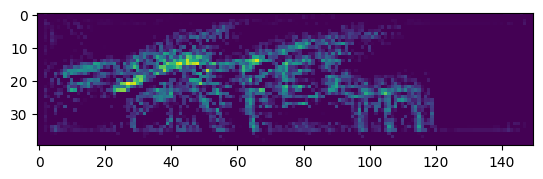

torch.Size([1, 5, 62])
8Mr3m


In [26]:
import matplotlib.pyplot as plt
with torch.no_grad():
    for X,y in train_loader:
        X=X[0]
        
        plt.imshow(X.numpy().transpose(1,2,0))
        plt.show()
        output=model(X.unsqueeze(0).to(device))
        X1=model.affn(X.unsqueeze(0).to(device))
        plt.imshow(X1[0].cpu().numpy().transpose(1,2,0))
        plt.show()
        print(output.shape)
        print(to_text(output.squeeze(0).argmax(axis=1)))
        break